In [1]:
import pandas as pd
import glob
import os
import numpy as np
import re
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


false          7408
partly true    6451
true           1696
Name: labelCode, dtype: int64


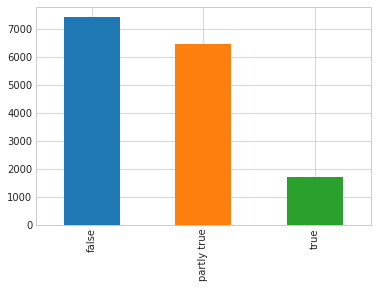

,claim,claimant,date,id,label,related_articles,labelCode
15550,the omnibus spending bill has ### pork barrel ...,John McCain,2009-02-25,17137,2,"[82947, 93503]",true
15551,representative maxine waters said muslims were...,,2017-06-06,17138,0,"[103780, 104726, 126025]",false
15552,we were not repeat were not told that waterboa...,Nancy Pelosi,2009-04-23,17139,0,"[11331, 68915, 2186, 2185, 88418, 81950]",false
15553,as of august #### members of the public could ...,,2018-05-14,17140,2,"[121353, 152864, 154411]",true
15554,we don get any of that information from the fe...,Scott Walker,2016-12-23,17141,1,"[69545, 88929, 14698]",partly true


In [2]:
train = pd.read_json ('data/train.json')
labels = {0:'false', 1:'partly true', 2:'true'}

def label(x):
    return labels[x]


def clean_text(text):
    text =  re.sub(r'\W+', ' ', text).lower()
    text = re.sub("\d","#", text)
    return ' '.join([i for i in text.split() if len(i.strip()) > 1])
  
train['claim'] = train.claim.apply(clean_text)

train['labelCode'] = train.label.apply(label)


print(train.labelCode.value_counts())

train.labelCode.value_counts().plot(kind='bar')

plt.show()
train.tail()


In [3]:
# print(glob.glob("data/train_articles/*.txt")[:100])
files = [f for f in glob.glob("data/train_articles/*.txt", recursive=True)]
# print(files[:10])
  
articles = []
for file in files:
    with open(file) as myfile:
        data = " ".join(line.rstrip() for line in myfile)
        data = clean_text(data)
        articles.append({'id' : os.path.basename(file)[:-4], 'text' : data})

articles_df = pd.DataFrame.from_dict(articles)
articles_df.reset_index(drop=True, inplace=True)
# articles_df.set_index('id', inplace=True)

articles_df.id = articles_df.id.astype(int)
articles_df.text = articles_df.text.apply(str)
# print(articles_df[articles_df.id == 112386]['text'])
# print(articles_df.describe())


articles_df.tail()

,id,text
64969,79940,rubio legalization first border security whene...
64970,81412,amid health law expansion some states trim med...
64971,112386,library of congress senate committee any commi...
64972,78733,fort bragg fort bragg is located just west of ...
64973,93980,obama russia reset disaster article chess cham...


In [4]:
# print(train_df.iloc[0]['related_articles'][0])

def process_dataset(df):
    train_complete = []
    for index, row in tqdm(df.iterrows()):
        for article in row['related_articles']:
            train_complete.append(
                {
                    'claim' : row['claim'],
                    'claimant' : row['claimant'],
                    'article' : articles_df.loc[articles_df['id'] == article].iloc[0]['text'],
                    'article_id' : article,
                    'date' : row['date'],
                    'label' : row['label']
                }
            )
    #     break
    return pd.DataFrame(train_complete)

train_df = process_dataset(train)
# print(train.loc[1])
train_df.to_csv('data/full_train.cvs')
train_df.tail()

15555it [00:40, 380.47it/s]


,article,article_id,claim,claimant,date,label
77675,charvat resort marketing group inc et al welco...,152864,as of august #### members of the public could ...,,2018-05-14,2
77676,update on class action lawsuit over cruise com...,154411,as of august #### members of the public could ...,,2018-05-14,2
77677,gov scott walker previews next year in state g...,69545,we don get any of that information from the fe...,Scott Walker,2016-12-23,1
77678,wrong donald trump says there no system to vet...,88929,we don get any of that information from the fe...,Scott Walker,2016-12-23,1
77679,david martin leading scholar in immigration co...,14698,we don get any of that information from the fe...,Scott Walker,2016-12-23,1


In [6]:
true_df = train_df[train_df.label == 2]

# dropping ALL duplicte values 
true_df = true_df.drop_duplicates(subset ="article_id", keep = 'last') 
true_df.reset_index(inplace=True)
  

true_df.to_csv('data/true_only.csv')
print('Average word length of article in train is {0:.0f}.'
      .format(np.mean(true_df['article'].apply(lambda x: len(x.split())))))

true_df.tail()

Average word length of article in train is 1155.


,index,article,article_id,claim,claimant,date,label
6949,77663,earmark reform #### spending bill contains ###...,82947,the omnibus spending bill has ### pork barrel ...,John McCain,2009-02-25,2
6950,77664,taxpayers for common sense update billion in e...,93503,the omnibus spending bill has ### pork barrel ...,John McCain,2009-02-25,2
6951,77674,robocalls from cruise lines could mean you re ...,121353,as of august #### members of the public could ...,,2018-05-14,2
6952,77675,charvat resort marketing group inc et al welco...,152864,as of august #### members of the public could ...,,2018-05-14,2
6953,77676,update on class action lawsuit over cruise com...,154411,as of august #### members of the public could ...,,2018-05-14,2


Average word length of article in train is 1118.
Average claim length 22.353326904532306


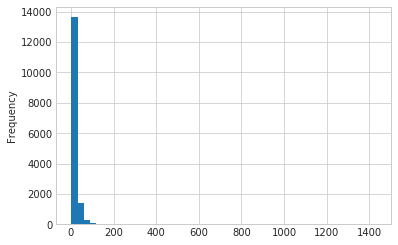

Average article length 1118.449364361129


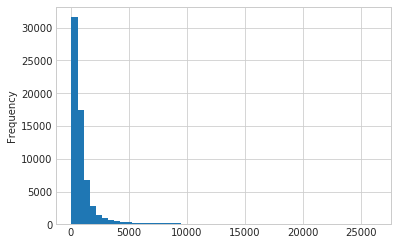

In [15]:
# print('Average word length of claim in train is {0:.0f}.'.format(np.mean(train['claim'].apply(lambda x: len(x.split())))))
print('Average word length of article in train is {0:.0f}.'.format(np.mean(articles_df['text'].apply(lambda x: len(x.split())))))

train['length'] = train['claim'].apply(lambda x: len(x.split()))
articles_df['length'] = articles_df['text'].apply(lambda x: len(x.split()))
print('Average claim length', train.length.mean())
train['length'].plot(bins=50, kind='hist')
plt.show()
print('Average article length', articles_df.length.mean())
articles_df['length'].plot(bins=50, kind='hist')

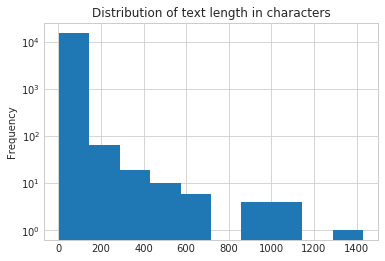

In [16]:
train['claim'].apply(lambda x: len(x.split())).plot(kind='hist', bins=10)
plt.yscale('log')
plt.title('Distribution of text length in characters')
plt.show()

In [ ]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(datapath("/home/sonic/.keras/datasets/GoogleNews-vectors-negative300.bin"),
                                          binary=True)  # C bin format

In [ ]:
print(model.most_similar('hello'))

In [ ]:
import random
import nltk
import numpy as np
import pickle
import sys
import os.path
import tensorflow as tf
import copy
# from .vocab import *
from nltk.corpus import stopwords as sw
import string
import re
import itertools
random.seed(42)

def helper_function(content,  query, model):
#     content = open(content_file).readlines()
#     summary = open(summary_file).readlines()
#     query = open(query_file).readlines()
    closest_pairs = {}
    stopwords = sw
    new_content, new_summary, new_query = [], [], []
    stopwords = set(stopwords.words('english') + ["<eos>", "<s>"] + string.punctuation.split() + ";:><".split())
    data = zip(content, query)

    __words = {}
    if os.path.exists("data/__words.pkl"):
        __words = pickle.load(open("data/__words.pkl", "rb"))
       
    for c, q in tqdm(data):
        c = " ".join(c.strip().split())
        q = " ".join(q.strip().split())
        c =  re.sub("\d","#",c)
        q = re.sub("\d","#",q)
        temp_c = c.strip().split()
        temp_q = q.strip().split()
        new_content.append(" ".join(temp_c))
        new_query.append(" ".join(temp_q))
        c_without_sw = set(temp_c + temp_q)- set(stopwords)
        q_without_sw = set(temp_q) -set(stopwords)
    
        if len(c_without_sw) < 20:
            continue

        for k in range(10,18):
            new_c = []
            new_q = []

            number_of_words_replace = k
            words_replace_c = random.sample(set(c_without_sw), number_of_words_replace)
#             print(words_replace_c)


            if len(set(q_without_sw)) >= 3:
                words_replace_q = random.sample(set(q_without_sw), random.randint(1,3))
            elif len(set(s_without_sw)) >= 1:
                words_replace_q = random.sample(set(q_without_sw),1)
            else:
                words_replace_q = []

            for w in temp_c:
                if w in words_replace_c:
#                     print(w)
                    if w not in __words and w in model:
                        __words[w] = model.most_similar(w)[0][0]
                    if w in __words:
                        new_c.append(__words[w])
                    else:
                        new_c.append(w)
                else:
                    new_c.append(w)

            for w in temp_q:
                if w in words_replace_c + words_replace_q:
                    if w not in __words and w in model:
                        __words[w] = model.most_similar(w)[0][0]
                    if w in __words:
                        new_q.append(__words[w])
                    else:
                        new_q.append(w)
                else:
                    new_q.append(w)

            new_content.append(" ".join(new_c))
            new_query.append(" ".join(new_q) + " <eos>")

    x = list(zip(new_content, new_query))
#     random.shuffle(x)
    cont , quer = [], []
    for c, q in x:
        cont.append(c)
#         summ.append(s)
        quer.append(q)

    if (os.path.exists('data/__words.pkl')) == False:
        with open("data/__words.pkl", "wb") as f:
            pickle.dump(__words, f)

    print ("Done")
    return cont, quer

In [ ]:
true = train_df[train_df.label == 2]
true.reset_index(inplace=True)
true.tail()

In [ ]:
articles = true.article[:1].values
claims = true.claim[:1].values

# print(articles[0])
cont, quer = helper_function(articles, claims, model)

In [ ]:
# print(articles)
print(articles[0])
print('*' * 50)
print(cont[0])